# Software Evolution - Practical Session
## Laws of software evolution based on code counting
## Academic year 2023-2024

### Write your answers under the questions that are present in this notebook  

#### Note: Print the final output of each cell in this notebook

#### Read the provided description document before proceeding with the following notebook

## 1.  Data preprocessing

To install packages, use :

pip install tqdm  pandas numpy matplotlib scikit-learn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from permetrics.regression import RegressionMetric
from scipy.optimize import curve_fit

### Import dataset

First, import the dataset that contains the total lines of code, total blank lines, total comment lines, total number of files, and release date for each tag.

In [3]:
# WRITE YOUR CODE HERE
LCC_DatasetA_df = pd.read_csv('data/LawContinuingChangeDatasetA.csv')
LCC_DatasetB_df = pd.read_csv('data/LawContinuingChangeDatasetB.csv')
LIG_df = pd.read_csv('data/LawIncreasingGrowthDataset.csv')

display(LIG_df)

,tag,code,blank,comment,nFiles,release_date
0,1.4,48551,8727,11154,419,2009-01-06
1,1.5.0,63240,11018,18457,512,2009-02-18
2,jaunty,70751,11840,19671,578,2009-06-23
3,1.5.1,67939,11618,18131,600,2009-08-05
4,1.5.2,68564,11555,11906,611,2009-08-17
...,...,...,...,...,...,...
56,4.3.1,456159,72232,219480,3405,2016-12-14
57,4.3.1.1,456159,72232,219480,3405,2017-02-02
58,4.4.0,472926,75325,216544,3597,2017-03-07
59,4.4.1,473836,75392,216678,3598,2017-05-08


### Dataset A : Major.Minor.Patch tag format

Filter out non-official releases such as alpha, beta, release candidates, milestones, branches, and unnumbered tags. Additionally, version numbers typically follow a Major.Minor.Patch format, but exceptions exist (e.g., 1.4, 3.3.0.1, 4.3.0.1, or 4.3.1.1). Versions with more than three components are disregarded, and two-component versions are treated as implicit three-component versions (e.g., 1.4 is interpreted as 1.4.0).  

Write a regular expression statement to identify tags following semantic versioning (major.minor.patch) guidelines. You can use the pattern: '^v?[0-9]+\.[0-9]+(\.[0-9]+)?$'  

Once you've applied this regex, print out the selected major.minor.patch dataset.

In [4]:
# WRITE YOUR CODE HERE
LIG_DatasetA_df = LIG_df[LIG_df['tag'].str.match('^v?[0-9]+\.[0-9]+(\.[0-9]+)?$')]
display(LIG_DatasetA_df)

,tag,code,blank,comment,nFiles,release_date
0,1.4,48551,8727,11154,419,2009-01-06
1,1.5.0,63240,11018,18457,512,2009-02-18
3,1.5.1,67939,11618,18131,600,2009-08-05
4,1.5.2,68564,11555,11906,611,2009-08-17
6,1.6.1,86799,14582,41327,744,2009-11-05
9,2.0.0,115586,18488,42717,1074,2010-06-05
10,2.0.1,115699,18492,42724,1074,2010-07-06
21,3.0.0,188246,29836,60879,1694,2012-02-07
22,3.0.1,189022,29945,61587,1696,2012-03-12
26,3.1.0,191269,29973,62628,1642,2012-06-22


### Dataset B : Major.Minor tag format

Starting from the previous data (**Dataset A**),  for each Major.Minor.Patch tag group, select the earliest version (e.g., for a set of 4.4.0, 4.4.1, and 4.4.2, consider 4.4.0 and rename it to 4.4).

In [5]:
LIG_DatasetB_df = LIG_DatasetA_df.copy()

# Split the 'tag' column into three new columns
LIG_DatasetB_df[['major', 'minor', 'patch']] = LIG_DatasetB_df['tag'].str.split('.', expand=True)

# Fill NaN values in 'patch' column with 0
LIG_DatasetB_df['patch'] = LIG_DatasetB_df['patch'].fillna(0)

# Convert the new columns to numeric type
LIG_DatasetB_df[['major', 'minor', 'patch']] = LIG_DatasetB_df[['major', 'minor', 'patch']].apply(pd.to_numeric)

# Sort the DataFrame
LIG_DatasetB_df = LIG_DatasetB_df.sort_values(['major', 'minor', 'patch'])

# Drop duplicates and keep the first occurrence
LIG_DatasetB_df = LIG_DatasetB_df.drop_duplicates(subset=['major', 'minor'], keep='first')

# Supprimer les colonnes 'major', 'minor', 'patch'
LIG_DatasetB_df = LIG_DatasetB_df.drop(columns=['major', 'minor', 'patch'])

# Split the 'tag' column into two parts at most
LIG_DatasetB_df['tag'] = LIG_DatasetB_df['tag'].apply(lambda x: '.'.join(x.split('.')[:2]))

display(LIG_DatasetB_df)

,tag,code,blank,comment,nFiles,release_date
0,1.4,48551,8727,11154,419,2009-01-06
1,1.5,63240,11018,18457,512,2009-02-18
6,1.6,86799,14582,41327,744,2009-11-05
9,2.0,115586,18488,42717,1074,2010-06-05
21,3.0,188246,29836,60879,1694,2012-02-07
26,3.1,191269,29973,62628,1642,2012-06-22
29,3.2,257934,43596,119688,2004,2012-12-17
38,3.3,350914,58798,159566,2682,2013-06-20
42,3.4,291555,48371,149981,2367,2013-10-24
45,4.0,357375,57707,159944,2790,2014-05-30


## 2. Law of Increasing Growth

### Software project's metrics

Visualize four plots representing the evolution of a software project's metrics, including the number of lines of code, blank lines, comment lines, and the number of files, as follows:  

1. Plot the metrics against software version numbers:  
   1.1) For version tags of the format major.minor.patch.  
   1.2) For version tags of the format major.minor.  
   Place these plots at positions (0,0) and (0,1) respectively.  
  
2. Plot the metrics against dates:  
   2.1) For version tags of the format major.minor.patch.  
   2.2) For version tags of the format major.minor.  
   Place these plots right below the corresponding version-based plots, at positions (1,0) and (1,1).  

Hint: Ensure proper datetime formatting for the dates in the datasets instead of storing them as strings.

For example, if you're working with a DataFrame:

fig, axes = plt.subplots(2, 2, figsize=(18, 10))  
dataset_a[['code', 'blank', 'comment', 'nFiles', 'tag']].plot(x='tag', ax=axes[0, 0], legend=True)  
.....  

axes[0, 0].set_xlabel('Major.Minor.Patch versions')  
.....  

plt.tight_layout()  
plt.show()

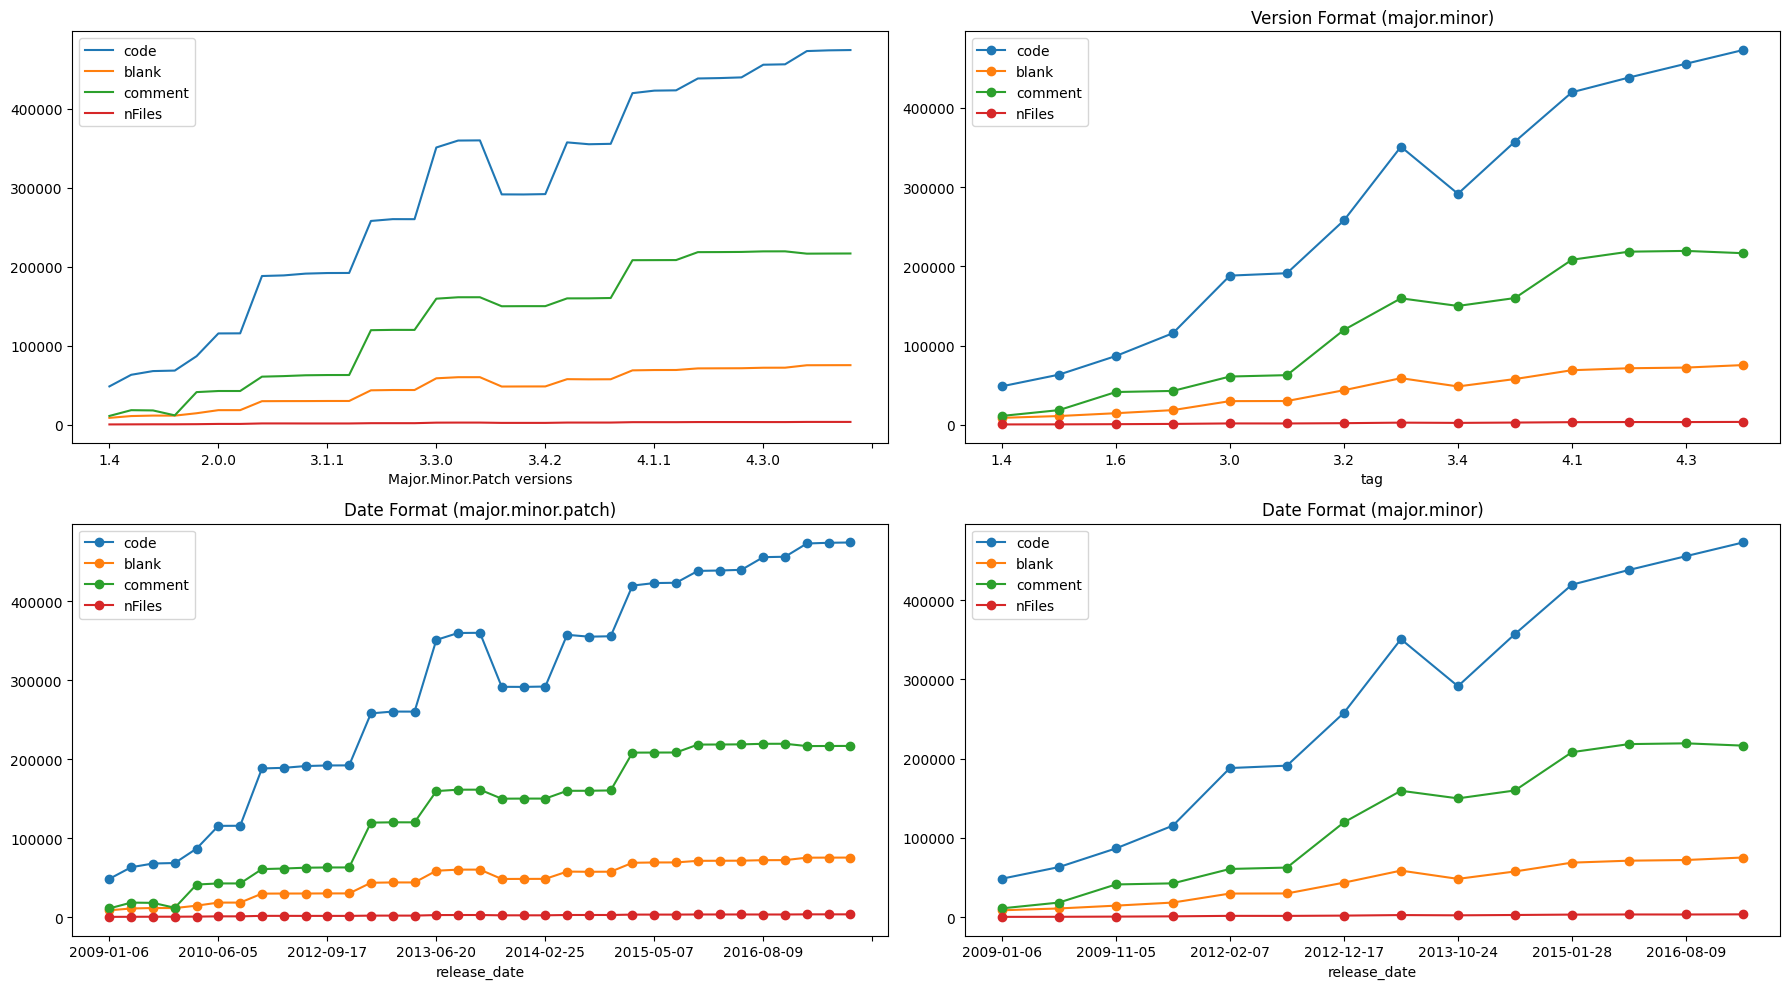

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10))  

LIG_DatasetA_df[['code', 'blank', 'comment', 'nFiles', 'tag']].plot(x='tag', ax=axes[0, 0], legend=True)    
axes[0, 0].set_xlabel('Major.Minor.Patch versions')  

# Plotting against software version numbers (major.minor)
LIG_DatasetB_df[['code', 'blank', 'comment', 'nFiles', 'tag']].plot(x='tag',  ax=axes[0, 1], marker='o')
axes[0, 1].set_title('Version Format (major.minor)')

# Plotting against dates (major.minor.patch)
LIG_DatasetA_df[['code', 'blank', 'comment', 'nFiles', 'tag','release_date']].plot(x='release_date', ax=axes[1, 0], marker='o')
axes[1, 0].set_title('Date Format (major.minor.patch)')

# Plotting against dates (major.minor)
LIG_DatasetB_df[['code', 'blank', 'comment', 'nFiles', 'tag','release_date']].plot(x='release_date', ax=axes[1, 1], marker='o')
axes[1, 1].set_title('Date Format (major.minor)')

plt.tight_layout()  
plt.show()

### Questions:

1. Do you find any difference between the plot that is having date in the x-axis and the plot that is having tag in the x-axis? If yes, then what is the difference? If no, then why is it same?

No. The order remains the same, as our focus is solely on the major version, without considering alpha, beta, etc. variants. Consequently, versions are published in the following order.

2. Which type of plot is preferable for software evolution analysis?   
    a) date in x-axis  
    b) tag in x-axis  
Why?

Date in x-axis.This allows you to modify existing labels or insert new ones. And the date value itself remains unchanged.

### Correlation 

Correlation is generally used to analyse the relationship between variables. Here, analyse the relationship between the number of lines of code and the number of files using Spearman correlation and Pearson correlation by considering **Dataset A**. Report the correlation upto 3 decimal places.

In [9]:
# Pearson correlation
pearson_corr = LIG_DatasetA_df['code'].corr(LIG_DatasetA_df['nFiles'], method='pearson')

# Spearman correlation
spearman_corr = LIG_DatasetA_df['code'].corr(LIG_DatasetA_df['nFiles'], method='spearman')

print(f"Pearson correlation: {pearson_corr:.3f}")
print(f"Spearman correlation: {spearman_corr:.3f}")

Pearson correlation: 0.998
Spearman correlation: 0.986


### Questions:

3. Do you find any difference in correlation values between Pearson and Spearman? Which correlation measure is preferable for this use case? why?

The difference is of the order of a few tenths. Pearson's correlation is preferable, as it is more correlated in this case.

4. Based on the above correlation value, please give your opinion on the relation between the number of lines and the number of files? Which of both size metrics do you propose to use in the remainder of your analysis?

Unsurprisingly, the two are highly correlated. As a result, we can use either one for further analysis. However, we recommend using the number of lines of code, as it is more accurate.

### Regression analysis

Visualize a linear regression analysis of the relationship between the release date and the total number of files by considering **Dataset B**.  

Hint:

1. Prepare the data: Convert the release date to integers and set number of files as the target variable.  
2. Apply linear regression analysis to understand the relationship between the release date and the total number of files.  
3. Calculate Mean Relative Error and ajusted R-squared metrics.    
4. Generate a scatter plot showing the release dates against the total number of files. Then, overlay the linear regression line on the plot.


Mean Relative Error: 0.065
R-squared: 0.972
Adjusted R-squared: 0.970


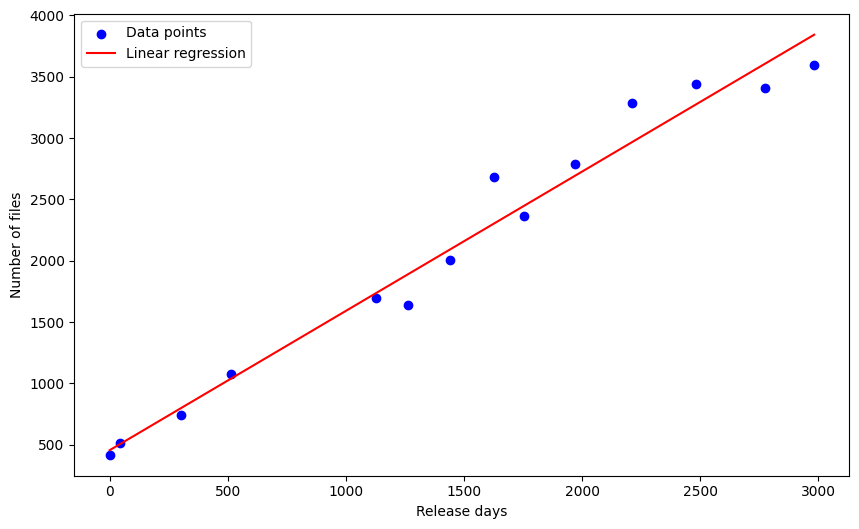

In [16]:
from sklearn.metrics import r2_score

# prepare the data, convert the release date to integers and set number of files as the target variable
LIG_DatasetB_df['release_date'] = pd.to_datetime(LIG_DatasetB_df['release_date'])
LIG_DatasetB_df['release_days'] = (LIG_DatasetB_df['release_date'] - LIG_DatasetB_df['release_date'].min()).dt.days

# apply linear regression analysis to understand the relationship between the release date and the total number of files
X = LIG_DatasetB_df['release_days'].values.reshape(-1, 1)
y = LIG_DatasetB_df['nFiles'].values

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# Calculate Mean Relative Error and R-squared metrics
metric = RegressionMetric(y, y_pred)
mre = metric.mean_relative_error()
r2 = r2_score(y, y_pred)

# Calculate adjusted R-squared
adjusted_r2 = 1 - (1-r2)*(len(y)-1)/(len(y)-X.shape[1]-1)

print(f"Mean Relative Error: {mre:.3f}")
print(f"R-squared: {r2:.3f}")
print(f"Adjusted R-squared: {adjusted_r2:.3f}")

# generate a scatter plot showing the release dates against the total number of files
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label='Data points')
plt.plot(X, model.predict(X), color='red', label='Linear regression')
plt.xlabel('Release days')
plt.ylabel('Number of files')
plt.legend()
plt.show()

### Questions:

5. Choose an option regarding the growth of the software. Motivate your choice using the 2D regression plot.  
    a) Linear  
    b) Sub-linear  
    c) Super-linear  

Option a) Linear best describes the software's growth, as the red regression line shows a constant and proportional increase in the number of files in relation to the number of days since release. This direct and uniform relationship between the two variables indicates linear growth.

6. Report the MRE and ajusted R-squared values.

Mean Relative Error: 0.065
R-squared: 0.972
Adjusted R-squared: 0.970

### Fitting & forecasting

Using **Dataset A**, apply parametric regression models (e.g., linear, exponential, power, quadratic, logarithmic) to predict the number of files in software releases based on historical data.

**Steps:**

1. Prepare Data:
   - Convert "release_date" to datetime format.
   - Calculate "release_days" as the number of days since the earliest release.

2. Split Data:
   - Separate data into features (release days) and target variable (number of files).
   - Split data into training and testing sets from the earliest release up to a specific point.

3. Build and Train Models:
   - Define regression models.
   - Fit models to training data (maybe using `curve_fit` from SciPy).

4. Forecast Future Data:
   - Predict the number of files for future release days using trained models.

5. Visualize Results:
   - Plot original data and forecasted values for each regression model.

6. Evaluate Models:
   - Calculate adjusted R-squared and mean relative error for each model using training and test data.

Linear model parameters: [  1.09246556 440.91431861]
Logarithmic model parameters: [1. 1.]
Quadratic model parameters: [-5.95697766e-05  1.27734508e+00  3.52186862e+02]
Exponential model parameters: [1. 1.]


/var/folders/rm/_8zrs2yx05987l76phdwdv2c0000gn/T/ipykernel_40206/2318051469.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LIG_DatasetA_df['release_date'] = pd.to_datetime(LIG_DatasetA_df['release_date'])
/var/folders/rm/_8zrs2yx05987l76phdwdv2c0000gn/T/ipykernel_40206/2318051469.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LIG_DatasetA_df['release_days'] = (LIG_DatasetA_df['release_date'] - LIG_DatasetA_df['release_date'].min()).dt.days
/Users/romeoibraimovski/Library/Mobile Documents/com~apple

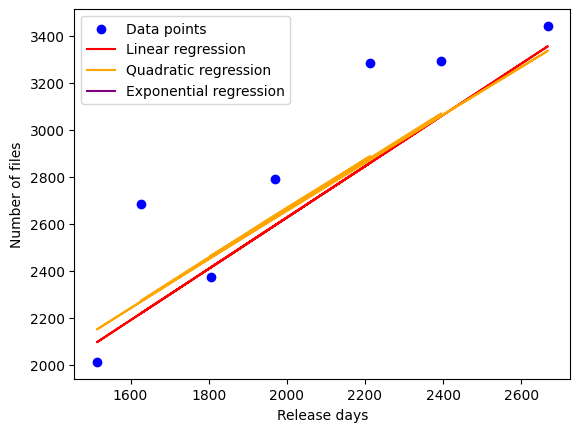

In [27]:
# Data preparation
# convert "release_date" to datetime format
LIG_DatasetA_df['release_date'] = pd.to_datetime(LIG_DatasetA_df['release_date'])
# calculate "release_days" as the number of days since the earliest release
LIG_DatasetA_df['release_days'] = (LIG_DatasetA_df['release_date'] - LIG_DatasetA_df['release_date'].min()).dt.days

# Split data
# separate data into features (release days) and target variable (number of files)
X = LIG_DatasetA_df['release_days']
y = LIG_DatasetA_df['nFiles']
# split data into training and testing sets from the earliest release up to a specific point
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build and Train Models
# define regression models
def linear(x, a, b):
    return a * x + b

def logarithmic(x, a, b):
    return a * np.log(b * x)

def quadratic(x, a, b, c):
    return a * x**2 + b * x + c

def exponential(x, a, b):
    return a * np.exp(b * x)

# fit models to training data
popt_linear, _ = curve_fit(linear, X_train, y_train)
popt_logarithmic, _ = curve_fit(logarithmic, X_train, y_train)
popt_quadratic, _ = curve_fit(quadratic, X_train, y_train)
popt_exponential, _ = curve_fit(exponential, X_train, y_train)

print("Linear model parameters:", popt_linear)
print("Logarithmic model parameters:", popt_logarithmic)
print("Quadratic model parameters:", popt_quadratic)
print("Exponential model parameters:", popt_exponential)

# Forecast Future Data
# predict the number of files for future release days using trained models
y_pred_linear = linear(X_test, *popt_linear)
y_pred_logarithmic = logarithmic(X_test, *popt_logarithmic)
y_pred_quadratic = quadratic(X_test, *popt_quadratic)
y_pred_exponential = exponential(X_test, *popt_exponential)

# Visualize Results
# plot original data and forecasted values for each regression model
# original data
plt.scatter(X_test, y_test, color='blue', label='Data points')
# linear regression
plt.plot(X_test, y_pred_linear, color='red', label='Linear regression')
# logarithmic regression
#plt.plot(X_test, y_pred_logarithmic, color='green', label='Logarithmic regression')
# quadratic regression
plt.plot(X_test, y_pred_quadratic, color='orange', label='Quadratic regression')
# exponential regression
plt.plot(X_test, y_pred_exponential, color='purple', label='Exponential regression')
plt.xlabel('Release days')
plt.ylabel('Number of files')
plt.legend()

In [36]:
# Evaluate Models
# calculate adjusted R-squared and mean relative error for each model using training and test data
# adjusted R-squared for each model
r2_linear = r2_score(y_test, y_pred_linear)
r2_logarithmic = r2_score(y_test, y_pred_logarithmic)
r2_quadratic = r2_score(y_test, y_pred_quadratic)

# mean relative error for each model
metric_linear = np.mean(np.abs((y_test - y_pred_linear) / y_test))
metric_logarithmic = np.mean(np.abs((y_test - y_pred_logarithmic) / y_test))
metric_quadratic = np.mean(np.abs((y_test - y_pred_quadratic) / y_test))

print("Linear model:")
print(f"Adjusted R-squared: {r2_linear:.3f}")
print(f"Mean Relative Error: {metric_linear:.3f}")

print("Logarithmic model:")
print(f"Adjusted R-squared: {r2_logarithmic:.3f}")
print(f"Mean Relative Error: {metric_logarithmic:.3f}")

print("Quadratic model:")
print(f"Adjusted R-squared: {r2_quadratic:.3f}")
print(f"Mean Relative Error: {metric_quadratic:.3f}")

Linear model:
Adjusted R-squared: 0.701
Mean Relative Error: 0.076
Logarithmic model:
Adjusted R-squared: -33.057
Mean Relative Error: 0.997
Quadratic model:
Adjusted R-squared: 0.742
Mean Relative Error: 0.076


### Questions:

7. Which regression model do you prefer for assessing the goodness of fit, based on the evaluation metrics scores? Why?

The linear model and quadratic model are the best choice for assessing the goodness of fit, as it has the highest adjusted R-squared value and the lowest mean relative error. If I have to choose one, I would choose the linear model because the growth is linear.

8. Which regression model do you prefer for assessing forecast accuracy, based on the evaluation metrics scores? Why?

The linear model and quadratic model are the best choice for assessing forecast accuracy, as it has the highest adjusted R-squared value and the lowest mean relative error. If I have to choose one, I would choose the linear model because the growth is linear.

### Modify the CLOC parameters

Exclude all bank lines and verify if the Law of Increasing Growth applies after this filtering

In [37]:
# WRITE YOUR CODE HERE

,tag,code,blank,comment,nFiles,release_date


Exclude all comment lines and verify if the Law of Increasing Growth applies after this filtering

In [ ]:
# WRITE YOUR CODE HERE

## 3. Law of Continuing Change

### Dataset A : Major.Minor.Patch tag format

Import Dataset A that contains number of lines of code that are added, modified, removed and same between two consecutive tags for the three component versions (major.minor.patch)

In [39]:
display(LCC_DatasetA_df)

,first_tag,second_tag,added,same,modified,removed,date
0,1.4,1.5.0,2681,43708,2162,17370,2009-02-18
1,1.5.0,1.5.1,34218,25802,3220,38813,2009-08-05
2,1.5.1,1.5.2,18832,46583,2420,19665,2009-08-17
3,1.5.2,1.6.1,10056,50312,8300,28187,2009-11-05
4,1.6.1,2.0.0,24236,55784,6779,53023,2010-06-05
5,2.0.0,2.0.1,4,115527,55,117,2010-07-06
6,2.0.1,3.0.0,49353,56547,9799,121900,2012-02-07
7,3.0.0,3.0.1,34,188138,74,810,2012-03-12
8,3.0.1,3.1.0,9059,176395,3568,11306,2012-06-22
9,3.1.0,3.1.1,77,191025,167,834,2012-09-17


Create a plot displaying all features together. Show the outcomes with dates on the x-axis and the corresponding numbers on the y-axis.

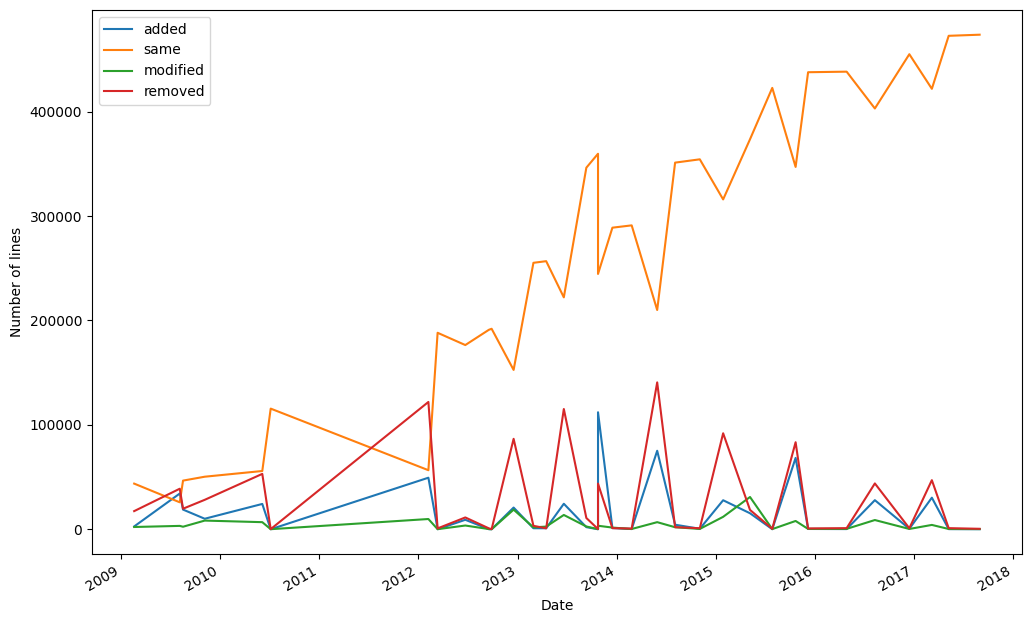

In [40]:
LCC_DatasetA_df['date'] = pd.to_datetime(LCC_DatasetA_df['date'])

LCC_DatasetA_df.set_index('date', inplace=True)

LCC_DatasetA_df.plot(figsize=(12, 8))
plt.xlabel('Date')
plt.ylabel('Number of lines')
plt.show()

### Dataset B : Major.Minor tag format

Import Dataset B that contains number of lines of code that are added, modified, removed and same between two consecutive tags for the minor versions (major.minor)

In [41]:
display(LCC_DatasetB_df)

,first_tag,second_tag,added,same,modified,removed,date
0,1.4,1.5.0,2681,43708,2162,17370,2009-02-18
1,1.5.0,1.6.1,38753,21466,3021,62312,2009-11-05
2,1.6.1,2.0.0,24236,55784,6779,53023,2010-06-05
3,2.0.0,3.0.0,49339,56466,9781,121999,2012-02-07
4,3.0.0,3.1.0,9091,175549,3606,12114,2012-06-22
5,3.1.0,3.2.0,20765,151608,18896,87430,2012-12-17
6,3.2.0,3.3.0,25240,216618,16076,118220,2013-06-20
7,3.3.0,3.4.0,104598,242521,3795,45239,2013-10-24
8,3.4.0,4.0.0,75798,208717,7040,141618,2014-05-30
9,4.0.0,4.1.0,27544,318189,11642,89832,2015-01-28


Produce a plot where all features are represented together. Present the outcomes with dates on the x-axis and the corresponding numbers on the y-axis.

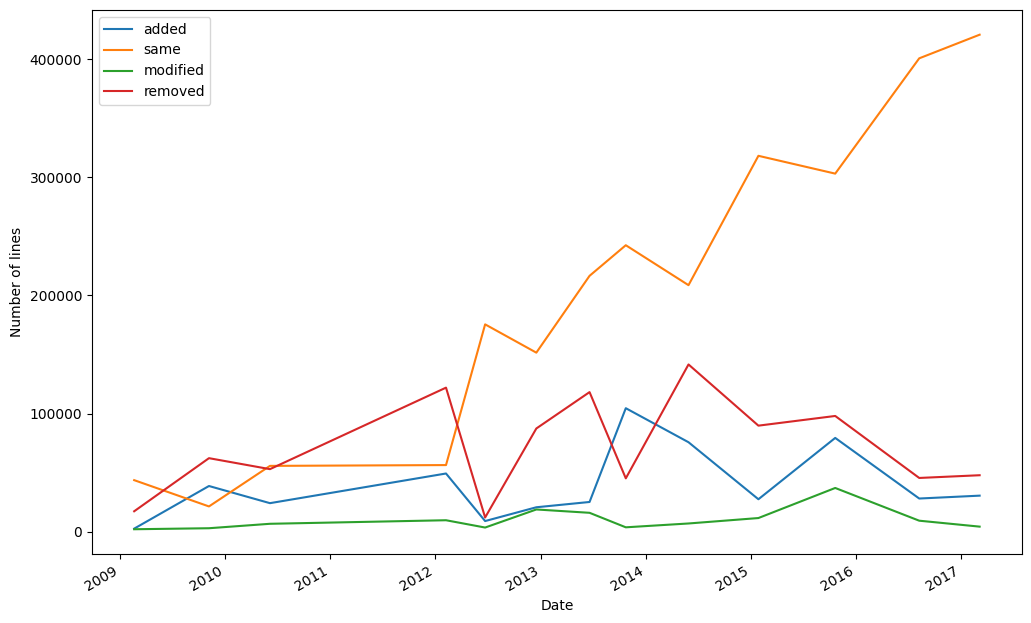

In [42]:
LCC_DatasetB_df['date'] = pd.to_datetime(LCC_DatasetB_df['date'])

LCC_DatasetB_df.set_index('date', inplace=True)

LCC_DatasetB_df.plot(figsize=(12, 8))
plt.xlabel('Date')
plt.ylabel('Number of lines')
plt.show()

### Question:

1. Do you find empirical support for the Law of Continuing Change ? Motivate your response.

Yes, the Law of Continuing Change is supported by the data. The graph shows that the number of lines added increases steadily over time, indicating ongoing growth and evolution of the software. Modified and deleted lines also show activity over the period, reflecting change.